# Problem set 3: Optimization and Root Finding: The Consumer Problem

We will take a look at solving the canonical utility maximization problem for the consumer.  

**Problem set structure:** 
* Each problem set consists of tasks and problems. _Tasks_ train you in using specific techniques, while _problems_ train you in solving actual economic problems. 
* Each problem set also contains solutions, which can be found in separate Python files.
* The Python files `A[..].py` do not run out of the box. But you can copy the code into your notebook or user module. 
* *You should really try to solve the tasks and problems on your own before looking at the answers!* 
* You goal should, however, not be to write everything from scratch. 
* Finding similar code from the lectures and adjusting it is completely ok. I rarely begin  completely from scratch, I figure out when I last did something similar and copy in the code to begin with. A quick peak at the solution, and then trying to write the solution yourself is also a very beneficial approach.

**Multiple solutions:** Within the field of numerical analysis there is often many more than one way of solving a specific problem. So the solution provided is just one example. If you get the same result, but use another approach, that might be just as good (or even better).

**Table of contents**<a id='toc0_'></a>    
- [1. Functions](#toc1_)    
- [2. Function continued](#toc2_)    
- [3. Methods to solve and optimize](#toc3_)    
  - [3.1 Brute‑Force Grid Search](#toc3_1_)    
  - [3.2 Bisection](#toc3_2_)    
  - [3.3 Newton's Method](#toc3_3_)    
  - [3.4 scipy.optimize](#toc3_4_)    
- [4. Other Optimizers - Comparing Methods (more difficult)](#toc4_)    
- [5. Sensitivity: Price shock](#toc5_)    
- [6. Sensitivity: Starting Values & Solver Choices](#toc6_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_'></a>[1. Functions](#toc0_)

Implement a Python version of this function:

$$ 
u(x_1,x_2) = (\alpha x_1^{-\beta} + (1-\alpha) x_2^{-\beta})^{-1/\beta} 
$$

In [20]:
# set autoreload so that changes in A*.py files are reflected without restarting the notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
# write your own code here
from A1 import utility_ces

## <a id='toc2_'></a>[2. Function continued](#toc0_)

Solve the above consumer problem with the CES utility function.

$$
u(x_1,x_2) = (\alpha x_1^{-\beta} + (1-\alpha) x_2^{-\beta})^{-1/\beta}
$$

Subject to the Budget Constraint:
$$ p_1 x_1 + p_2 x_2 \le I, \quad x_1 \ge 0,\; x_2 \ge 0. $$

Tasks: Use your function from above that contains the CES utility function and embed it into another function *value_of_choice_ces* that returns the value of utility *u*.

In [22]:

import numpy as np

# Use these baseline parameters
alpha = 0.5
beta = 0.000001
I = 10
p1 = 1
p2 = 2


In [23]:
## write the functions here

In [24]:
import A2

Next, we will compare different methods to solve the consumer problem.

## <a id='toc3_'></a>[3. Methods to solve and optimize](#toc0_)

### <a id='toc3_1_'></a>[3.1 Brute‑Force Grid Search](#toc0_)
Set up a grid of the budget set and solve the consumer problem on the grid.

**Idea:** Search over a grid for  $c_1 \in [0, I/p_1]$, and  $c_2 \in [0, I/p_2]$ to find the values of $c_1$ and $c_2$ that maximize utility.


In [25]:
from types import SimpleNamespace
from grid_solve import print_solution


**Task**: Modify the grid search function below to add the additional parameter for the CES utility function $\beta$ and print the results. Note that you also need to use of the utility function. Make sure it runs below.

In [26]:
def find_best_choice(u_func,alpha,I,p1,p2,N1,N2,do_print=True):
    
    # a. allocate numpy arrays
    shape_tuple = (N1,N2)
    x1_values = np.empty(shape_tuple)
    x2_values = np.empty(shape_tuple)
    u_values = np.empty(shape_tuple)
    
    # b. start from guess of x1=x2=0
    x1_best = 0
    x2_best = 0
    u_best = u_func(0,0,alpha=alpha)
    
    # c. loop through all possibilities
    for i in range(N1):
        for j in range(N2):
            
            # i. x1 and x2 (chained assignment)
            x1_values[i,j] = x1 = (i/(N1-1))*I/p1
            x2_values[i,j] = x2 = (j/(N2-1))*I/p2
            
            # ii. utility
            if p1*x1 + p2*x2 <= I: # u(x1,x2) if expenditures <= income 
                u_values[i,j] = u_func(x1,x2,alpha=alpha)
            else: # u(0,0) if expenditures > income, not allowed
                u_values[i,j] = u_func(0,0,alpha=alpha)
            
            # iii. check if best sofar
            if u_values[i,j] > u_best:
                x1_best = x1_values[i,j]
                x2_best = x2_values[i,j] 
                u_best = u_values[i,j]
    
    # d. print
    if do_print:
        print_solution(x1_best,x2_best,u_best,I,p1,p2)

    return SimpleNamespace(x1_best=x1_best,x2_best=x2_best,u_best=u_best,x1_values=x1_values,x2_values=x2_values,u_values=u_values)




In [27]:
from A3_1 import find_best_choice
N1 = 100
N2 = 100

sol = find_best_choice(utility_ces, alpha, beta, I, p1, p2, N1, N2, do_print=True)


x1 = 4.9495
x2 = 2.5253
u  = 3.5354
I-p1*x1-p2*x2 = -0.00000000
x1*p1/I = 0.4949


### <a id='toc3_2_'></a>[3.2 Bisection](#toc0_)

Use the bisection function from the lecture. Make sure you understand what it does first. Then, define the first‑order condition of the consumer problem with the modified utility function, which we can enforce by a **single equation in $ x_1 $**:  


FOC (interior):
$$\frac{\partial u/\partial x_1}{\partial u/\partial x_2}
=\frac{\alpha\,x_1^{-(\beta+1)}}{(1-\alpha)\,x_2^{-(\beta+1)}}
=\frac{\alpha}{1-\alpha}\left(\frac{x_2}{x_1}\right)^{\beta+1}
=\frac{p_1}{p_2}.$$

Single equation in $x_1$ (with $x_2(x_1)=\tfrac{I-p_1x_1}{p_2}$):
$$F(x_1)\equiv \frac{\alpha}{1-\alpha}\left(\frac{I-p_1x_1}{p_2x_1}\right)^{\beta+1}-\frac{p_1}{p_2}=0.$$

We solve $ F(x_1) = 0 $ on $[0, I/p_1]$ using **bisection**.



**Algorithm:** `bisection()`

1. Set $a_0 = a$ and $b_0 = b$ where $f(a)$ and $f(b)$ has oposite sign, $f(a_0)f(b_0)<0$
2. Compute $f(m_0)$ where $m_0 = (a_0 + b_0)/2$ is the midpoint.
3. Determine the next sub-interval $[a_1,b_1]$:
  * If $f(a_0)f(m_0) < 0$ (different signs) then $a_1 = a_0$ and $b_1 = m_0$ (i.e. focus on the range $[a_0,m_0]$).
  * If $f(m_0)f(b_0) < 0$ (different signs) then $a_1 = m_0$ and $b_1 = b_0$ (i.e. focus on the range $[m_0,b_0]$).
4. Repeat step 2 and step 3 until $|f(m_k)| < \epsilon$.

In [28]:
def bisection(f, a, b, tol=1e-10, max_iter=500):
    fa, fb = f(a), f(b)
    if np.isnan(fa) or np.isnan(fb):
        raise ValueError("f(a) or f(b) is NaN.")
    if fa == 0.0: 
        return a, 0
    if fb == 0.0: 
        return b, 0
    if fa*fb > 0:
        raise ValueError("Bisection: root not bracketed. Choose a,b with opposite signs.")
    it = 0
    while (b - a) > tol and it < max_iter:
        m  = 0.5*(a + b)
        fm = f(m)
        if fm == 0.0:
            a = b = m
            break
        if fa*fm < 0:
            b, fb = m, fm
        else:
            a, fa = m, fm
        it += 1
    return 0.5*(a + b), it



In [29]:
# Set up the function F(c1) = 0 to solve for c1*
## write your functions here


# Choose a bracket around the known solution
# a_bis, b_bis
# set the tolerance and the maximum number of iterations
## 
## 

### MODIFY ## 
## run the bisection method, compute x2 and print the solution
# x1_bis, it_bis = bisection(F, a_bis, b_bis, tol=1e-15, max_iter=500)

# print(f"Bisection: x1*={x1_bis:.10f}, x2*={x2_bis:.10f}, iterations={it_bis}")

In [30]:
import importlib, A3_2
importlib.reload(A3_2)   # pick up the change



Bisection: x1*=5.0000017329, x2*=2.4999991336, iterations=53


<module 'A3_2' from 'c:\\Users\\jfn232\\Dropbox\\CPH\\01_Teaching\\winter_term25\\ProgEcon-exercises-private\\PS_Optimization\\A3_2.py'>

### <a id='toc3_3_'></a>[3.3 Newton's Method](#toc0_)

Apply Newton on $ F(c_1)=0 $ where $F$ is defined above.  
We compute $ F'(c_1)$ analytically for the CES consumer problem:

**Fully expanded form**
$
F'(c_1)\;=\;-\;\frac{\alpha}{1-\alpha}\,(\beta+1)\,\frac{I}{p_2\,c_1^{2}}
\left(\frac{I-p_1 c_1}{p_2\,c_1}\right)^{\beta}.
$

In [31]:
### Write your code here ###

## Hint: use F from the exercise above, define Fprime (the expanded form from above) as a function,
#  and use the Newton function from the lecture.


In [32]:
import importlib, A3_3
importlib.reload(A3_3)   # pick up the change 

Newton: x1*=4.9999982671, x2*=2.5000008664, iterations=6


<module 'A3_3' from 'c:\\Users\\jfn232\\Dropbox\\CPH\\01_Teaching\\winter_term25\\ProgEcon-exercises-private\\PS_Optimization\\A3_3.py'>

### <a id='toc3_4_'></a>[3.4 scipy.optimize](#toc0_)

Solve the consumer problem now using the scipy.minimize_scalar function. Define adequate bounds.



In [33]:
### write your code here ###


In [34]:
import importlib, A3_4
importlib.reload(A3_4)   # pick up the change 

4.99995818905239 2.500020905473805 3.535533693620822


<module 'A3_4' from 'c:\\Users\\jfn232\\Dropbox\\CPH\\01_Teaching\\winter_term25\\ProgEcon-exercises-private\\PS_Optimization\\A3_4.py'>


## <a id='toc4_'></a>[4. Other Optimizers - Comparing Methods (more difficult)](#toc0_)

Solve the problem now with *SLSQP* and compare the number of iterations, function evaluations, speed, and precision with *Nelder-Mead*.


In [35]:
### write your code here ###

In [36]:
import importlib, A4
importlib.reload(A4)   # pick up the change

SLSQP       x1*=5.0000000000  u=3.5355336936  nit=1  nfev=2  time=0.7 ms  error=1.73e-06
Nelder-Mead x1*=5.0000000000  u=3.5355336936  nit=13  nfev=26  time=1.0 ms  error=1.73e-06


<module 'A4' from 'c:\\Users\\jfn232\\Dropbox\\CPH\\01_Teaching\\winter_term25\\ProgEcon-exercises-private\\PS_Optimization\\A4.py'>

## <a id='toc5_'></a>[5. Sensitivity: Price shock](#toc0_)

- Now, assume that the price p1 doubles. Recompute (x1_star, x2_star, u_star) for each $\beta$.
- For each $\beta$, compute percentage changes relative to baseline.
- Plot two panels, where panel A contains quantities (the percentage change in x1_star and x2_star) and panel B contains the percentage change in u_star.
- Interpretation: Briefly explain how the substitution elasticity (lower beta) shapes x1_star, x2_star, and the utility.

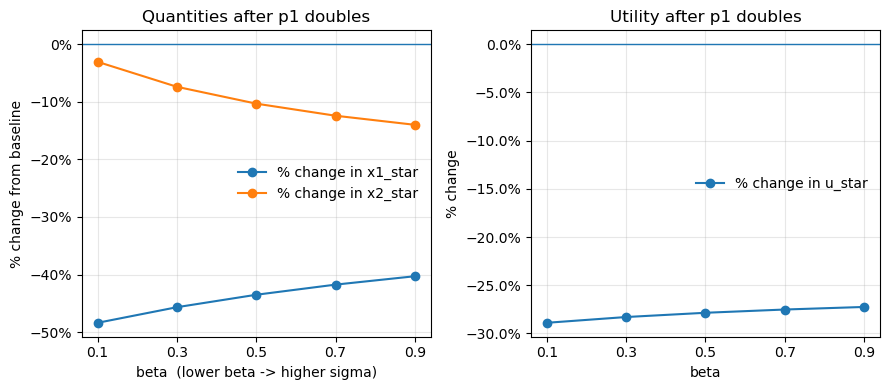

<module 'A5' from 'c:\\Users\\jfn232\\Dropbox\\CPH\\01_Teaching\\winter_term25\\ProgEcon-exercises-private\\PS_Optimization\\A5.py'>

In [39]:
import importlib, A5
importlib.reload(A5)   # pick up the change

## <a id='toc6_'></a>[6. Sensitivity: Starting Values & Solver Choices](#toc0_)

- Try different starting values for Newton and `minimize`.
- Discuss your main observations and take-aways regarding number of iterations and function evaluations.
- Which one was your favorite solver in this application? Why?


In [38]:

# Try out and discuss